# **Titre du Projet :** Analyse de Sentiments sur les Avis de l'Aéroport Paris-Charles-de-Gaulle (CDG)


---


**Sujet :** Évaluation de l'expérience des passagers à travers l'analyse des avis sur l'aéroport Paris-Charles-de-Gaulle.

**Objectif :** L'objectif de ce projet est d'analyser les sentiments exprimés par les passagers à l'égard de l'aéroport Paris-Charles-de-Gaulle. En extrayant des données à partir de critiques en ligne, nous chercherons à comprendre les tendances générales de satisfaction des passagers à CDG, à identifier les aspects les plus souvent loués ou critiqués, et à fournir des recommandations spécifiques basées sur ces résultats.

# Topic Modeling for airports

Topic modeling is an unsupervised machine learning technique that’s capable of scanning a set of documents, detecting word and phrase patterns within them, and automatically clustering word groups and similar expressions that best characterize a set of documents.

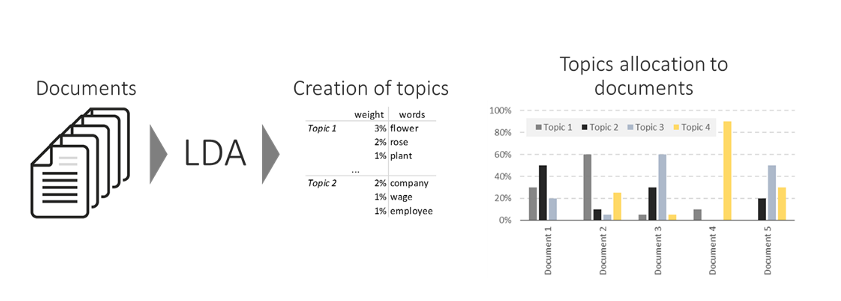

In [26]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Corpus Construction

In [27]:
# On prends les airports d'europe

base_url = "https://www.airlinequality.com/airport-reviews/paris-cdg-airport/"
pages = 10
page_size = 100

reviews_dict = {"h3_text": [], "Review": []}

for i in range(1, pages + 1):
    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    for title, content_div in zip(parsed_content.find_all("h3", {"class": "text_sub_header userStatusWrapper"}),
                                  parsed_content.find_all("div", {"class": "text_content"})):
        # Extract text from <h3> and <div> tags
        h3_text = title.get_text() if title else ""
        review_text = content_div.get_text()

        # Append to dictionary
        reviews_dict["h3_text"].append(h3_text)
        reviews_dict["Review"].append(review_text)

    print(f"   ---> {len(reviews_dict['h3_text'])} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 753 total reviews
Scraping page 9
   ---> 753 total reviews
Scraping page 10
   ---> 753 total reviews


In [28]:
# Convert dictionary to DataFrame
df = pd.DataFrame(reviews_dict)

In [29]:
# Extract information into new columns
df[['Name', 'Country', 'Date']] = df['h3_text'].str.extract(r'\n\n(.+?) \((.+?)\) (.+)$')

# Drop the original 'h3_text' column
df = df.drop('h3_text', axis=1)

# Reorder columns
df = df[['Name', 'Country', 'Date', 'Review']]

In [30]:
df.head()

,Name,Country,Date,Review
0,Ian Whitehead,United Kingdom,7th December 2023,Not Verified | Diabolical queue at security t...
1,F Lartine,United States,20th November 2023,"✅ Trip Verified | Today, I got in line for pa..."
2,Guy Cary,United Kingdom,11th November 2023,Not Verified | Appalling lack of service movi...
3,L Oliver,United States,27th October 2023,✅ Trip Verified | There are awful passport con...
4,C Wilson,Australia,12th October 2023,"✅ Trip Verified | Departing from Terminal 1, t..."


# Exploratory Data Analysis

In [31]:
df.shape

(753, 4)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     753 non-null    object
 1   Country  753 non-null    object
 2   Date     753 non-null    object
 3   Review   753 non-null    object
dtypes: object(4)
memory usage: 23.7+ KB


In [33]:
print('Number of duplicated rows :', df.duplicated().sum())

Number of duplicated rows : 0


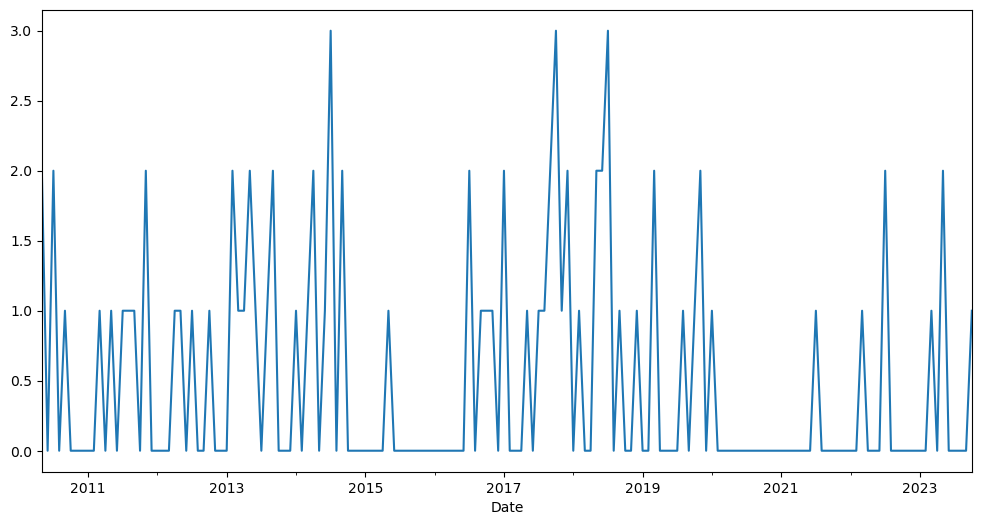

In [34]:
# Define a custom date parsing function
def custom_date_parser(date_str):
    return pd.to_datetime(date_str, format='%dst %B %Y', errors='coerce') or pd.to_datetime(date_str, format='%dth %B %Y', errors='coerce')

# Apply the custom date parser to the 'Date' column
df['Date'] = df['Date'].apply(custom_date_parser)

# Plot time series (e.g., number of reviews over time)
df.set_index('Date')['Review'].resample('M').count().plot(figsize=(12, 6))
plt.show()

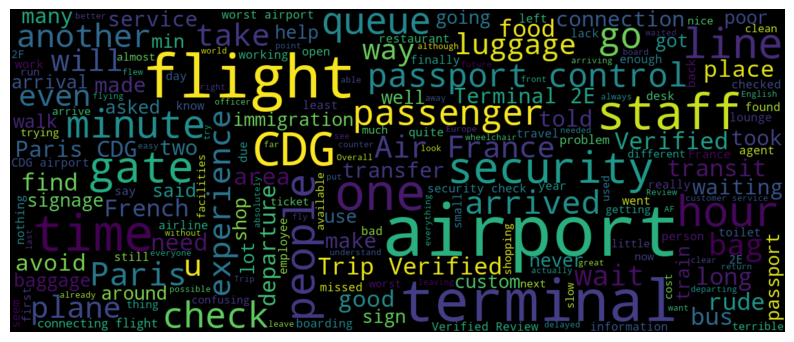

In [35]:
from wordcloud import WordCloud

# Combine all reviews into a single string
all_reviews = ' '.join(df['Review'])

# Generate and plot a word cloud
wordcloud = WordCloud(width=1200, height=500, random_state=21, max_font_size=110).generate(all_reviews)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


# Data Cleaning and Preprocessing

In [36]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [38]:
# Remove "Trip Verified |" and "Not Verified |"

# Preprocessing function

def preprocess_text(text):
    # Remove patterns
    text = text.lstrip('✅ Trip Verified | ')
    text = text.lstrip('Not Verified |')

    # Remove HTML Tags
    text = re.sub(r'<.*?>', '', text)

    # Change text to lower case
    text = text.lower()

    # Tokenization
    words = word_tokenize(text)

    # Remove StopWords
    words = [word for word in words if word not in stop_words]

    # Remove stopwords and apply stemming ( Normalisation )
    #words = [ps.stem(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]

    return ' '.join(words)

In [39]:
# Apply preprocessing to 'Review' column
df_cleaned = pd.DataFrame()
df_cleaned['Review'] = df['Review'].apply(preprocess_text)

In [40]:
df_cleaned.head()

,Review
0,diabolical queue security 2g 2 open ! spent 30...
1,"ay , got line passport control terminal 2e 9:3..."
2,appalling lack service moving t2e 2f yet . imm...
3,awful passport control services . passport con...
4,"departing terminal 1 , procedure bag drop secu..."


# Sentiment Analysis

on va faire un analyse de sentiment sur tout le corpus avant de faire le topic  modeling et appliquer l'analyse de sentiment sur chasue topic afin de faire des recommendation

In [41]:
def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [42]:
def tag_cal(num):
    if num is None:
        return 'Neutral'
    elif num < 0:
        return 'Negative'
    elif num > 0:
        return 'Positive'
    else:
        return 'Neutral'

In [43]:
df_cleaned['Polarity'] = df_cleaned['Review'].apply(polarity_calc)
df_cleaned['Tag'] = df_cleaned['Polarity'].apply(tag_cal)

In [44]:
df_cleaned.head(10)

,Review,Polarity,Tag
0,diabolical queue security 2g 2 open ! spent 30...,-0.116667,Negative
1,"ay , got line passport control terminal 2e 9:3...",-0.070163,Negative
2,appalling lack service moving t2e 2f yet . imm...,0.077500,Positive
3,awful passport control services . passport con...,-0.190000,Negative
4,"departing terminal 1 , procedure bag drop secu...",-0.159722,Negative
5,ansfer cdg hanoi amsterdam . terrible experien...,-0.082780,Negative
6,"worst service-oriented , discriminating disres...",-0.116250,Negative
7,humiliating experience cdg staff member handle...,-0.042347,Negative
8,strong > verified | loved paris want return dr...,0.202384,Positive
9,landed terminal 3 thursday 2pm one working cus...,-0.120833,Negative


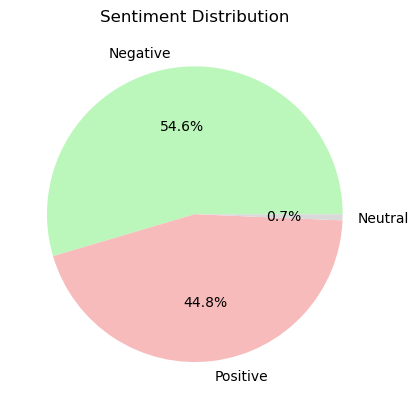

In [45]:
sentiment_counts = df_cleaned['Tag'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette(['#b3ffb3', '#ffb3b3', '#d9d9d9'], desat=0.8))
plt.title('Sentiment Distribution')
plt.show()

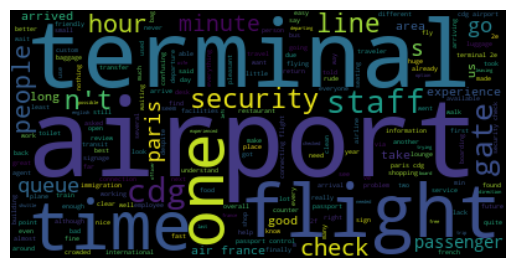

In [46]:
text1= " "
for ind in df_cleaned.index:
    if df_cleaned['Tag'][ind] == "Positive":
        text1 = text1 + df_cleaned['Review'][ind]
wordcloud_pos = WordCloud().generate(text1)
# Display the generated image:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

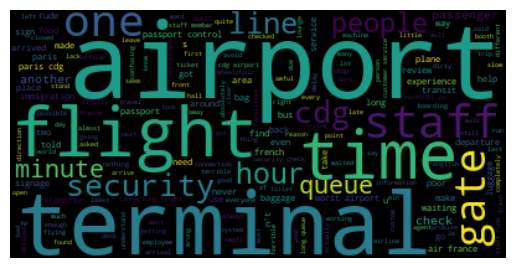

In [47]:
text2= " "
for ind in df_cleaned.index:
    if df_cleaned['Tag'][ind] == "Negative":
        text2 = text2 + df_cleaned['Review'][ind]
wordcloud_negative = WordCloud().generate(text2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

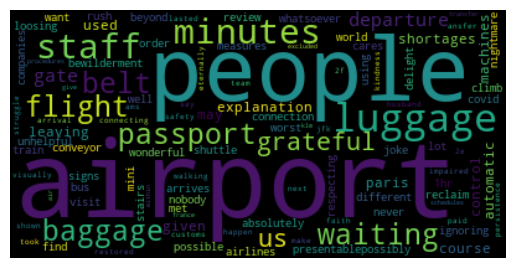

In [48]:
text3= " "
for ind in df_cleaned.index:
    if df_cleaned['Tag'][ind] == "Neutral":
        text3 = text3 + df_cleaned['Review'][ind]
wordcloud_neutral = WordCloud().generate(text3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorization

### Word Embedding - Word2Vec

In [49]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

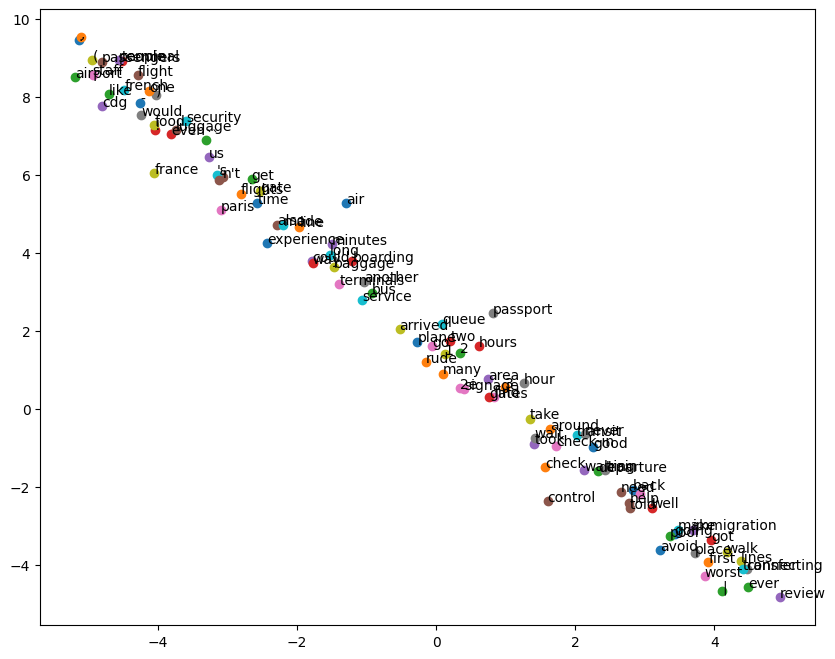

In [ ]:
# Assuming you already have tokenized_reviews as a list of tokenized words
# Example: tokenized_reviews = [word_tokenize(review) for review in df_cleaned['Review']]

tokenized_reviews = [word_tokenize(review) for review in df_cleaned['Review']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Extract word vectors
word_vectors = word2vec_model.wv

# Choose words to visualize
words_to_visualize = list(word_vectors.key_to_index.keys())[:100]

# Get the vectors for selected words
vectors = [word_vectors[word] for word in words_to_visualize]

vectors_array = np.array(vectors)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors_array)

# Visualize the word embeddings
plt.figure(figsize=(10, 8))
for i in range(len(words_to_visualize)):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(words_to_visualize[i], (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.show()


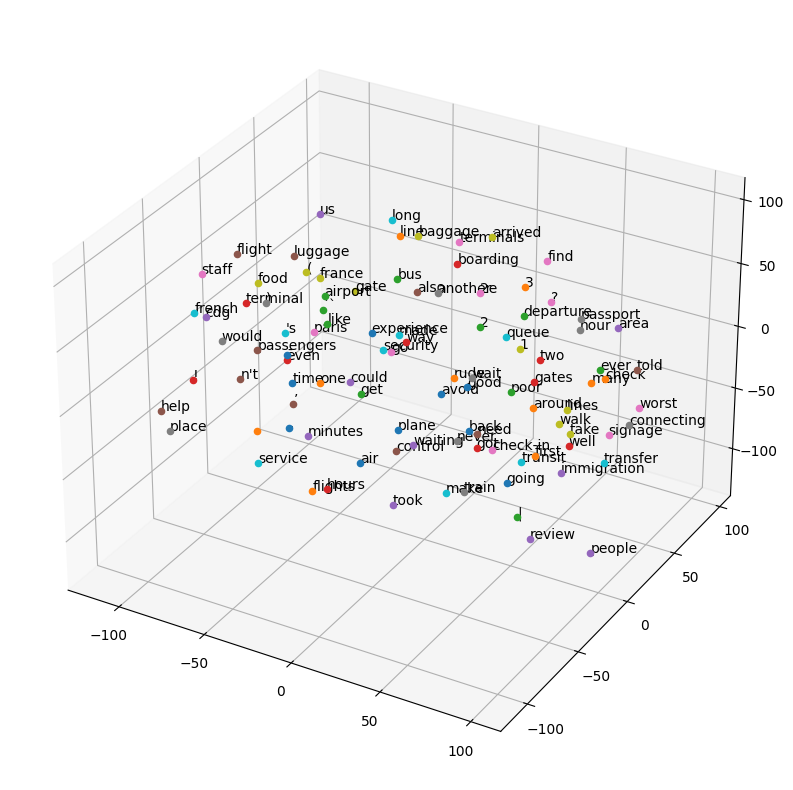

In [ ]:
# Assuming you already have tokenized_reviews as a list of tokenized words
# Example: tokenized_reviews = [word_tokenize(review) for review in df_cleaned['Review']]

tokenized_reviews = [word_tokenize(review) for review in df_cleaned['Review']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Extract word vectors
word_vectors = word2vec_model.wv

# Choose words to visualize
words_to_visualize = list(word_vectors.key_to_index.keys())[:100]

# Get the vectors for selected words
vectors = [word_vectors[word] for word in words_to_visualize]

vectors_array = np.array(vectors)

# Apply t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3, random_state=42)
vectors_3d = tsne.fit_transform(vectors_array)

# Visualize the word embeddings in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(words_to_visualize)):
    ax.scatter(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2])
    ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2], words_to_visualize[i])

plt.show()


# Model

## Topic Modeling using LDA

In [59]:
import spacy
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import nltk
from nltk.tokenize import word_tokenize
import re
import pandas as pd
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from transformers import pipeline
from tqdm.notebook import tqdm

#### Phrases Modeling : n-gram (Bigram - Trigram) Models

In [51]:
# Assuming df_cleaned['Review'] contains the preprocessed text
data_words = [review.split() for review in df_cleaned['Review']]

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Data Transformation: Corpus and Dictionary

In [52]:
# Define functions for stopwords, bigrams, trigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [53]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [54]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Model Building

In [55]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### Compute Model Perplexity and Coherence Score

In [56]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

[(0,
  '0.022*"get" + 0.020*"airport" + 0.017*"take" + 0.014*"staff" + '
  '0.014*"flight" + 0.013*"time" + 0.012*"minute" + 0.011*"hour" + '
  '0.011*"security" + 0.010*"check"'),
 (1,
  '0.025*"staff" + 0.019*"airport" + 0.014*"call" + 0.013*"push" + 0.012*"way" '
  '+ 0.012*"unfriendly" + 0.012*"min" + 0.012*"flight" + 0.011*"queue" + '
  '0.009*"security"'),
 (2,
  '0.041*"terminal" + 0.029*"airport" + 0.014*"time" + 0.010*"way" + '
  '0.009*"flight" + 0.009*"security" + 0.008*"staff" + 0.008*"people" + '
  '0.008*"service" + 0.008*"transfer"'),
 (3,
  '0.021*"airport" + 0.019*"flight" + 0.016*"security" + 0.015*"staff" + '
  '0.015*"terminal" + 0.014*"check" + 0.012*"time" + 0.012*"get" + 0.011*"go" '
  '+ 0.010*"experience"'),
 (4,
  '0.015*"lounge" + 0.014*"queue" + 0.012*"check" + 0.012*"business" + '
  '0.011*"walk" + 0.011*"airport" + 0.010*"area" + 0.010*"main" + '
  '0.009*"security" + 0.009*"facility"'),
 (5,
  '0.027*"line" + 0.024*"airport" + 0.019*"flight" + 0.016*"queu

### Hyperparameter Tuning

Alpha - Beta - Number of Topics

In [57]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary,
                                           num_topics=k, random_state=100,
                                           chunksize=100, passes=10,
                                           alpha=a, eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized,
                                         dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [60]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 7
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs * 0.75)), corpus]
corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [], 'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}


if 1 == 1:
    pbar = tqdm(total=(len(beta) * len(alpha) * len(topics_range) * len(corpus_title)), leave=False)

    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through the number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterate through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)
    
    pbar.close()

  0%|          | 0/300 [00:00<?, ?it/s]

In [61]:
df_results = pd.DataFrame(model_results)

# Find the row with the highest coherence score
best_params_row = df_results.loc[df_results['Coherence'].idxmax()]

# Display the best parameters
print("Best Parameters:")
print("Number of Topics:", best_params_row['Topics'])
print("Alpha:", round(best_params_row['Alpha'], 3))
print("Beta:", round(best_params_row['Beta'], 3))
print("Coherence Score:", best_params_row['Coherence'])


Best Parameters:
Number of Topics: 6
Alpha: 0.61
Beta: 0.91
Coherence Score: 0.40185080290146663


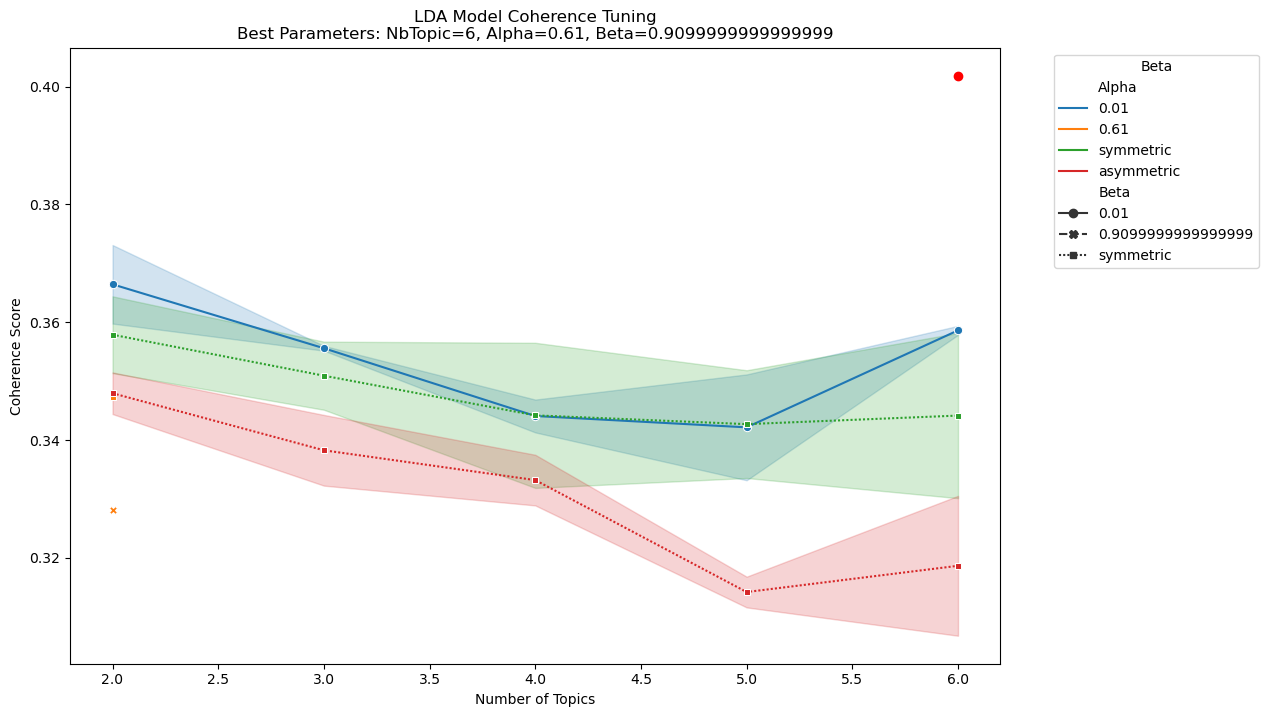

In [62]:
# Find the rows with the highest coherence scores for each set of parameters
best_params_rows = df_results.groupby(['Alpha', 'Beta']).apply(lambda x: x.loc[x['Coherence'].idxmax()]).reset_index(drop=True)
best_params_row = best_params_rows.loc[best_params_rows['Coherence'].idxmax()]

# Find two other rows with coherence scores less than the best
lesser_params_rows = df_results[df_results['Coherence'] < best_params_row['Coherence']].head(2)

# Convert 'Alpha' and 'Beta' columns to string for proper plotting
df_results['Alpha'] = df_results['Alpha'].astype(str)
df_results['Beta'] = df_results['Beta'].astype(str)

# Filter the DataFrame for the specified sets of parameters
selected_params = [('symmetric', 'symmetric'), ('asymmetric', 'symmetric'), ('0.01', '0.01')]
selected_df = df_results[df_results[['Alpha', 'Beta']].apply(tuple, axis=1).isin(selected_params) | df_results.index.isin([best_params_row.name] + lesser_params_rows.index)]

# Create a line plot for the selected parameters
plt.figure(figsize=(12, 8))
sns.lineplot(x='Topics', y='Coherence', hue='Alpha', style='Beta', markers=True, data=selected_df)

# Display the best coherence score for the best parameters
best_coherence = best_params_row['Coherence']
best_alpha = best_params_row['Alpha']
best_beta = best_params_row['Beta']
best_topic = best_params_row['Topics']

# Plot a red dot on the curve where the best coherence score is achieved
plt.scatter(best_params_row['Topics'], best_coherence, marker='o', color='red')

# Display the legends of the presented plots
plt.legend(title='Beta', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'LDA Model Coherence Tuning\nBest Parameters: NbTopic={best_topic}, Alpha={best_alpha}, Beta={best_beta}')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()


### Final Model with the optimal hyperparameters

In [63]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=best_topic,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=best_alpha,
                                           eta=best_beta)

In [64]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"minute" + 0.014*"flight" + 0.012*"get" + 0.012*"check" + '
  '0.011*"take" + 0.010*"gate" + 0.010*"airport" + 0.009*"wait" + 0.009*"line" '
  '+ 0.009*"bus"'),
 (1,
  '0.005*"push" + 0.004*"unfriendly" + 0.004*"call" + 0.003*"system" + '
  '0.002*"shout" + 0.002*"computer" + 0.002*"realise" + 0.002*"unhelpful" + '
  '0.002*"barrier" + 0.002*"outdated"'),
 (2,
  '0.019*"terminal" + 0.014*"airport" + 0.007*"long" + 0.006*"quite" + '
  '0.006*"get" + 0.006*"take" + 0.006*"walk" + 0.006*"arrive" + 0.005*"little" '
  '+ 0.005*"easy"'),
 (3,
  '0.020*"terminal" + 0.019*"airport" + 0.018*"flight" + 0.014*"security" + '
  '0.013*"staff" + 0.012*"time" + 0.011*"get" + 0.010*"check" + 0.009*"go" + '
  '0.008*"long"'),
 (4,
  '0.007*"terminal" + 0.007*"well" + 0.005*"area" + 0.005*"queue" + '
  '0.005*"arrival" + 0.005*"bad" + 0.005*"walk" + 0.005*"passenger" + '
  '0.005*"departure" + 0.005*"lounge"'),
 (5,
  '0.020*"line" + 0.010*"flight" + 0.010*"make" + 0.009*"queue" + '
  '0.0

In [65]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40185080290146663


### Word Clouds of Top N Keywords in Each Topic

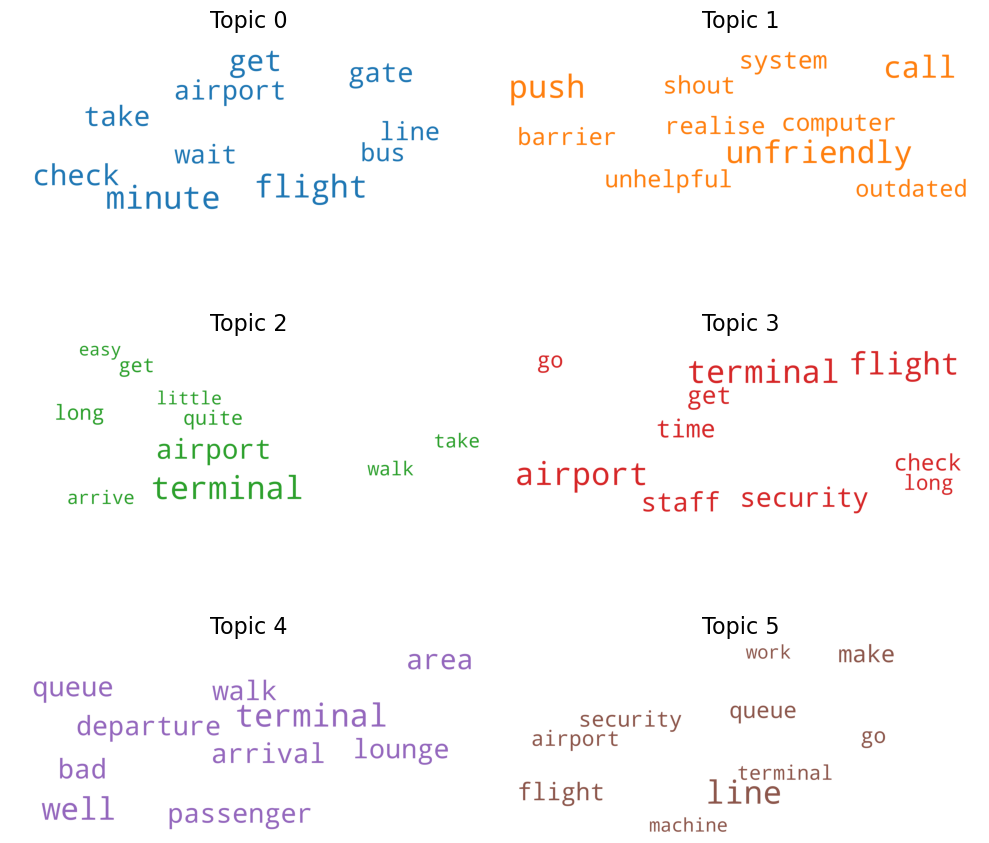

In [66]:
# Assuming you have your trained LDA model and stop words
topics = lda_model.show_topics(formatted=False)

# More colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=4500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [67]:

import pyLDAvis.gensim

#pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, sort_topics=False)
pyLDAvis.display(vis)

In [69]:
pyLDAvis.save_html(vis, 'lda_visualization.html')

## Sentiment Analysis using BERT Transformer (on each topic)

In [31]:
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification

# Load the sentiment analysis model
sentiment_analysis = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Assuming 'corpus' is your list of documents and 'lda_model' is your trained LDA model
topic_sentiments = []

for i in range(lda_model.num_topics):
    # Extract documents associated with the current topic
    topic_docs = [doc for j, doc in enumerate(corpus) if lda_model.get_document_topics(doc)[0][0] == i]

    # Convert the topic documents to strings
    topic_text = ' '.join(' '.join(id2word[word_id] for word_id, _ in doc) for doc in topic_docs)

    # Truncate or pad the input to match the model's expected size
    max_length = 512
    topic_text = topic_text[:max_length]

    # Use sentiment analysis on the truncated or padded topic text
    result = sentiment_analysis(topic_text)

    # Get the average sentiment score for the topic
    sentiment_scores = [res['score'] for res in result]
    avg_sentiment_score = np.mean(sentiment_scores)

    # Get the sentiment label
    sentiment_label = 'Positive' if avg_sentiment_score > 0.7 else 'Negative' if avg_sentiment_score < 0.3 else 'Neutral'

    topic_sentiments.append((i, avg_sentiment_score, sentiment_label))

# Print or use the sentiment scores and labels for each topic
for topic, sentiment_score, sentiment_label in topic_sentiments:
    print(f"Topic {topic} - Average Sentiment Score: {sentiment_score} - Sentiment: {sentiment_label}")


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Topic 0 - Average Sentiment Score: 0.6816782355308533 - Sentiment: Neutral
Topic 1 - Average Sentiment Score: 0.7119067311286926 - Sentiment: Positive
Topic 2 - Average Sentiment Score: 0.2846149206161499 - Sentiment: Negative
Topic 3 - Average Sentiment Score: 0.23740269243717194 - Sentiment: Negative
Topic 4 - Average Sentiment Score: 0.2846149206161499 - Sentiment: Negative
Topic 5 - Average Sentiment Score: 0.2846149206161499 - Sentiment: Negative
